# Modeling

## Open items to do 
 - utilize cross validation to measure model performance
 - utilize cross validation to make predictions on training data not the test data
 - set classes to be predicted with a measure of Biden's victory that takes MOE into consideration**
 - include measures such as precison and recall to really gauge performance of models
 - most important 
 - **ROC curves**
 - XGBOOST model**
 - can this be done with a deep learning model
 - Readme
 - start making dashboards/outputs
 - get new data and add to see if scores are any better**
 - feature importance - take out the feature that might be to close to the target**
 - see if GridSearch has CrossValidation
 - **clean up the EDA notebook**
 - SQL

In [1]:
#pip install eli5

In [2]:
import seaborn as sns
import pandas as pd
import datetime as dt
import eli5
import waterfall_chart
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be 

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer 
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.regressor import PredictionError
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import classification_report
from yellowbrick.classifier import ROCAUC
import xgboost as xgb

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
# getting tweet df up and running
Master_tweet_dataset = pd.read_csv('data/Master_Tweet_modelready.csv')
Master_tweet_dataset = Master_tweet_dataset.drop(['clean_text','Unnamed: 0'],axis=1)
Master_tweet_dataset.columns

Index(['date', 'username', 'replies_count', 'retweets_count', 'likes_count',
       'video', 'geo', 'positive', 'death', 'word_count', 'avg_word_length',
       'stopwords_count', 'char_count', 'stopwords', 'Sentiment', 'Topic',
       'Target'],
      dtype='object')

In [5]:
Master_tweet_dataset = Master_tweet_dataset.drop(['username','geo','stopwords','Topic'],axis=1)

In [6]:
## Variable Designation#
X = Master_tweet_dataset.drop('Target',axis=1)
y= Master_tweet_dataset.iloc[:,-1]

In [7]:
#apply the LabelEncoder to y values to get rid of continuous error
lab_enc = LabelEncoder()
training_scores_encoded = lab_enc.fit_transform(y)


## Data Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, training_scores_encoded,test_size=.15)

In [9]:
#def datetime_to_int(dt):
 #   return int(dt.strftime("%Y%m%d"))

In [10]:
X_train['date'] = X_train['date'].astype(int)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Pipeline Creation

In [11]:
#Classifer being used in current Pipeline so future changes can be made
Model = DummyRegressor()

#splitting dataframe into numeric and categoric columns
numeric_features = ['likes_count', 'replies_count','retweets_count','word_count','avg_word_length','stopwords_count',
                   'char_count','Sentiment']
numeric_transformer = Pipeline([('scaler',StandardScaler())])

#categorical_features = ['Target']
#categorical_transformer = Pipeline([('encoder',LabelEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])#,('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', Model)])

## Models

### Baseline Model

In [12]:
clf.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['likes_count',
                                                   'replies_count',
                                                   'retweets_count',
                                                   'word_count',
                                                   'avg_word_length',
                                                   'stopwords_count',
                                                   'char_count',
                                                   'Sentiment'])])),
                ('classifier', DummyRegressor())])

In [13]:
clf.score(X_test,y_test)

-0.00029293986514700165

### Decision Tree Classifier

In [14]:
#Classifer being used in current Pipeline so future changes can be made
Model = DecisionTreeClassifier()

#splitting dataframe into numeric and categoric columns
numeric_features = ['likes_count', 'replies_count','retweets_count','word_count','avg_word_length','stopwords_count',
                   'char_count','Sentiment']
numeric_transformer = Pipeline([('scaler',StandardScaler())])

categorical_features = ['Target']
categorical_transformer = Pipeline([('Encoder',LabelEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),('cat', categorical_transformer, categorical_features)
        ])
    
clf_DT = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', Model)])



In [15]:
## Finding best parameters
parameters={'criterion': ('gini','entropy'), 'splitter': ('best', 'random')}

model = DecisionTreeClassifier()

clf_DT = GridSearchCV(model, parameters)

clf_DT.fit(X_train,y_train)


GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'splitter': ('best', 'random')})

In [16]:
#Results of GridSearchCV
print('\n ============================================================================================')
print('\n Results of the GridSearchCV on Decision Tree Classifier')
print('\n ============================================================================================')
print('\n The best parameters to use in a model are: \n',clf_DT.best_params_)
print('\n The best score achieved is: \n',clf_DT.best_score_ )
print('\n ============================================================================================')



 Results of the GridSearchCV on Decision Tree Classifier


 The best parameters to use in a model are: 
 {'criterion': 'entropy', 'splitter': 'random'}

 The best score achieved is: 
 0.5924742905058455



In [17]:
#fitting and making predictions with model
clf_DT = DecisionTreeClassifier(criterion='gini',splitter='best')
clf_DT_model = clf_DT.fit(X_train,y_train)
clf_DT.predict(X_test)

array([1, 0, 0, ..., 0, 0, 0])

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


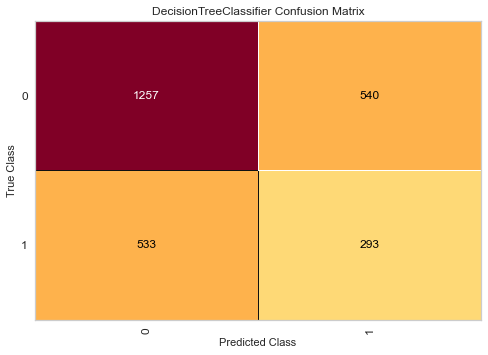

<AxesSubplot:title={'center':'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [18]:
#Confusion Matrix
model = DecisionTreeClassifier()
visualizer = ConfusionMatrix(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


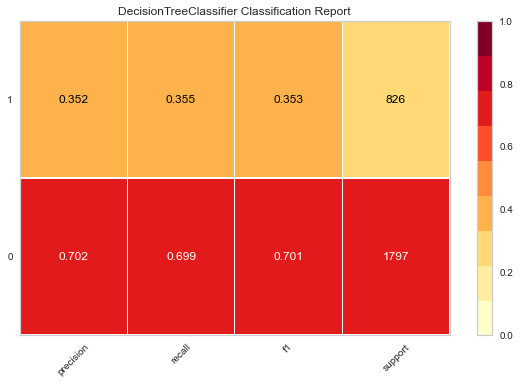

In [19]:
#classification report
visualizer = classification_report(model,X_train, y_train, X_test, y_test, support=True)

### Random Forest Classifier

In [20]:
## Finding best parameters
parameters={'n_estimators': (100,500,1100), 'criterion': ('gini', 'entropy'),
           'max_features': ('auto', 'sqrt', 'log2')}

model = RandomForestClassifier()

clf_RFC = GridSearchCV(model, parameters)

In [21]:
clf_RFC_model = clf_RFC.fit(X_train,y_train)

In [22]:
#Results of GridSearchCV
print('\n ============================================================================================')
print('\n Results of the GridSearchCV on Random Forest Classifier')
print('\n ============================================================================================')
print('\n The best parameters to use in a model are: \n',clf_RFC.best_params_)
print('\n The best score achieved is: \n',clf_RFC.best_score_ )



 Results of the GridSearchCV on Random Forest Classifier


 The best parameters to use in a model are: 
 {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 500}

 The best score achieved is: 
 0.6878445430095227


In [23]:
#Classifer being used in current Pipeline so future changes can be made
Model = RandomForestClassifier(criterion='entropy',max_features='log2',n_estimators=1100)

#splitting dataframe into numeric and categoric columns
numeric_features = ['likes_count', 'replies_count','retweets_count','word_count','avg_word_length','stopwords_count',
                   'char_count','Sentiment']
numeric_transformer = Pipeline([('scaler',StandardScaler())])

#categorical_features = ['Target']
#categorical_transformer = Pipeline([('imputer',SimpleImputer(strategy='constant',fill_value='Likely Trump'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])
        #('cat', categorical_transformer, categorical_features)])

clf_RFC = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', Model)])

In [24]:
#Fitting the model
clf_RFC_model = clf_RFC.fit(X_train,y_train)
#Making predictions with the model
clf_RFC.predict(X_test)

array([1, 0, 0, ..., 0, 0, 0])

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


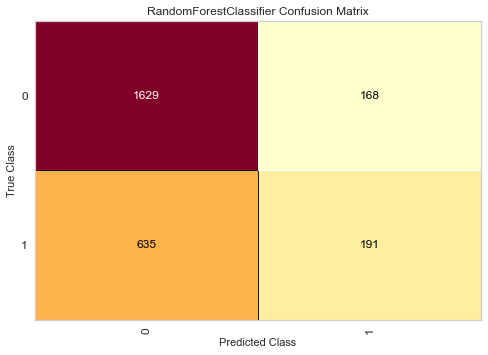

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [25]:
#ConfusionMatrix
model = RandomForestClassifier()
visualizer = ConfusionMatrix(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


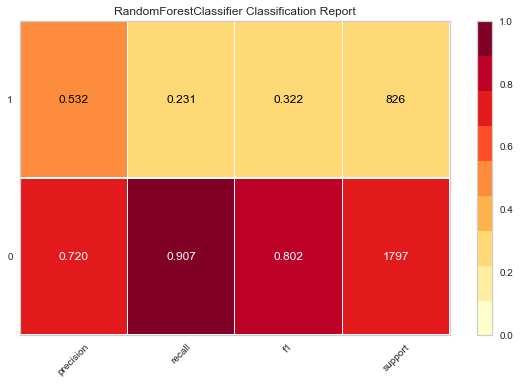

In [26]:
#classification report
visualizer = classification_report(model,X_train, y_train, X_test, y_test, support=True)

### XGBoost Classifier

In [27]:
#installing XGBoost
#!pip install xgboost

In [28]:
#creating DMatrix
data_dmatrix = xgb.DMatrix(data=X,label=training_scores_encoded)



In [29]:
## Finding best parameters
parameters={'learning_rate': (0.01,0.25,0.75), 'n_estimators': (100,1000),
           'max_depth': (3,4,5)}

model = xgb.XGBClassifier()

clf_XGB = GridSearchCV(model, parameters)

In [ ]:
clf_XGB.fit(X_train,y_train)

In [ ]:
#Results of GridSearchCV
print('\n ============================================================================================')
print('\n Results of the GridSearchCV on XGBoost Classifier')
print('\n ============================================================================================')
print('\n The best parameters to use in a model are: \n',clf_XGB.best_params_)
print('\n The best score achieved is: \n',clf_XGB.best_score_ )

In [ ]:
#Classifer being used in current Pipeline so future changes can be made
Model = xgb.XGBClassifier(learning_rate= 0.01,max_depth=3, n_estimators= 100)

#splitting dataframe into numeric and categoric columns
numeric_features = ['likes_count', 'replies_count','retweets_count','word_count','avg_word_length','stopwords_count',
                   'char_count','Sentiment']
numeric_transformer = Pipeline([('scaler',StandardScaler())])

#categorical_features = ['Target']
#categorical_transformer = Pipeline([('imputer',SimpleImputer(strategy='constant',fill_value='Likely Trump'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])
        #('cat', categorical_transformer, categorical_features)])

clf_XGB = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', Model)])

In [ ]:
#fitting and making predictions with model
clf_XGB = Model
clf_XGB_model = clf_XGB.fit(X_train,y_train)
clf_XGB.predict(X_test)

In [ ]:
#ConfusionMatrix
model = clf_XGB
visualizer = ConfusionMatrix(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

In [ ]:
#classification report
visualizer = classification_report(clf_XGB,X_train, y_train, X_test, y_test, support=True)

## Model Selection

In [ ]:
# Set up the matplotlib figure
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

#assigning variables
x = models
y1 = precision_scores
y2 = recall_scores

#plotting on axes
sns.barplot(x=x, y=y1, palette="rocket", ax=ax1)
sns.barplot(x=x, y=y2, palette="rocket", ax=ax2)

ax1.set_title('Precision Scores')
ax2.set_title('Recall Scores')
ax1.set_ylabel(y1)
ax2.set_ylabel(y2)

plt.show()

In [ ]:
#ROC curves
def ROC_Curve (Model, X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.15)
    model = Model
    visualizer = ROCAUC(Model)

    visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)        # Evaluate the model on the test data
    visualizer.show()     
    
model_selection: [clf_DT,clf_RFC,clf_XGB]

In [ ]:
interact(ROC_Curve,Model=[clf_DT,clf_RFC,clf_XGB],X=fixed(X),y=fixed(training_scores_encoded))

# Model Choice

With minimal difference between the Random Forest and XGBoost model in terms of precision and recall, the deciding factor was which model fit the data better. Based on the ROC curves above, the RandomForest Classifier is the better model for making predictions with data not yet seen.